In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define hyperparameters
hyperparams = {
    "batch_size": 64,
    "learning_rate": 0.005, #0.001
    "weight_decay": 1e-2,
    "num_epochs": 20,
    "dropout_rate": 0.7,
    "lr_decay_step": 1,
    "lr_decay_gamma": 0.7,
    "lambda_l1": 1e-3,
    "image_size": (128, 128),
    "train_test_split": 0.8
}

In [3]:
# Check for CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Define the CNN model
class LowLightClassifier(nn.Module):
    def __init__(self):
        super(LowLightClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),

            nn.Linear(64 * (hyperparams["image_size"][0] // 4) * (hyperparams["image_size"][1] // 4), 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(hyperparams["dropout_rate"]),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.network(x)

In [5]:
# Data loading with Data Augmentation
transform = transforms.Compose([
    transforms.Resize(hyperparams["image_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])


#data_dir = r"D:\SANTIAGO\MASTERS\OBS\Programa\11. TFM\crack_restoration_system\dataset\lol_dataset\our485"
data_dir = r"D:\SANTIAGO\MASTERS\OBS\Programa\11. TFM\crack_restoration_system\dataset\cracks"

low_light_dir = os.path.join(data_dir, "LowLight_Positive")       #low    LowLight_Positive
good_light_dir = os.path.join(data_dir, "Positive")        #high   Positive


class_to_idx = {"low": 1, "high": 0}

dataset = datasets.ImageFolder(data_dir, transform=transform)
dataset.class_to_idx = class_to_idx

train_size = int(hyperparams["train_test_split"] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=False)

In [6]:
# Model, loss function, optimizer
model = LowLightClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=hyperparams["lr_decay_step"], gamma=hyperparams["lr_decay_gamma"])

In [7]:
# Training loop
train_losses = []
start_time = time.time()
for epoch in range(hyperparams["num_epochs"]):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        l1_regularization = sum(torch.sum(torch.abs(param)) for param in model.parameters())
        loss = criterion(outputs, labels) + hyperparams["lambda_l1"] * l1_regularization
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch + 1}/{hyperparams['num_epochs']}, Loss: {train_loss:.4f}, Time: {epoch_time:.2f}s")

total_time = time.time() - start_time
print(f"Total Training Time: {total_time:.2f}s")

Epoch 1/20, Loss: 8.9280, Time: 954.69s
Epoch 2/20, Loss: 3.0138, Time: 106.20s
Epoch 3/20, Loss: 2.1722, Time: 105.16s
Epoch 4/20, Loss: 1.5893, Time: 102.71s
Epoch 5/20, Loss: 1.1583, Time: 98.39s
Epoch 6/20, Loss: 0.8529, Time: 98.70s
Epoch 7/20, Loss: 0.6306, Time: 103.20s
Epoch 8/20, Loss: 0.4730, Time: 104.79s
Epoch 9/20, Loss: 0.3620, Time: 104.84s
Epoch 10/20, Loss: 0.2767, Time: 104.82s
Epoch 11/20, Loss: 0.2268, Time: 104.57s
Epoch 12/20, Loss: 0.1845, Time: 109.55s
Epoch 13/20, Loss: 0.1716, Time: 105.12s
Epoch 14/20, Loss: 0.1495, Time: 105.59s
Epoch 15/20, Loss: 0.1300, Time: 105.79s
Epoch 16/20, Loss: 0.1191, Time: 98.79s
Epoch 17/20, Loss: 0.1082, Time: 97.61s
Epoch 18/20, Loss: 0.1041, Time: 99.55s
Epoch 19/20, Loss: 0.1017, Time: 98.12s
Epoch 20/20, Loss: 0.0983, Time: 99.75s
Total Training Time: 2907.95s


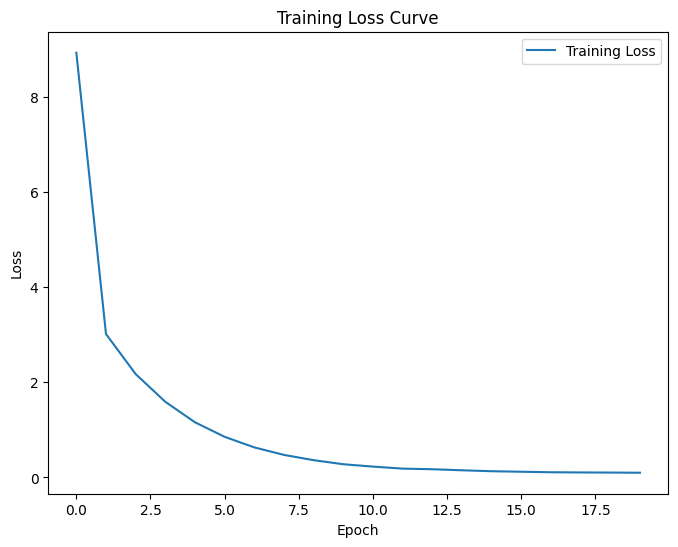

In [8]:
# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [9]:
# Evaluate the model
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

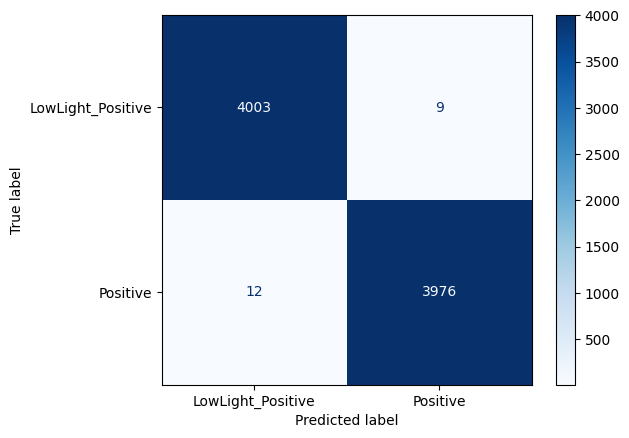

In [10]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
display.plot(cmap="Blues")
plt.show()

In [11]:
# Classification report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

                   precision    recall  f1-score   support

LowLight_Positive       1.00      1.00      1.00      4012
         Positive       1.00      1.00      1.00      3988

         accuracy                           1.00      8000
        macro avg       1.00      1.00      1.00      8000
     weighted avg       1.00      1.00      1.00      8000



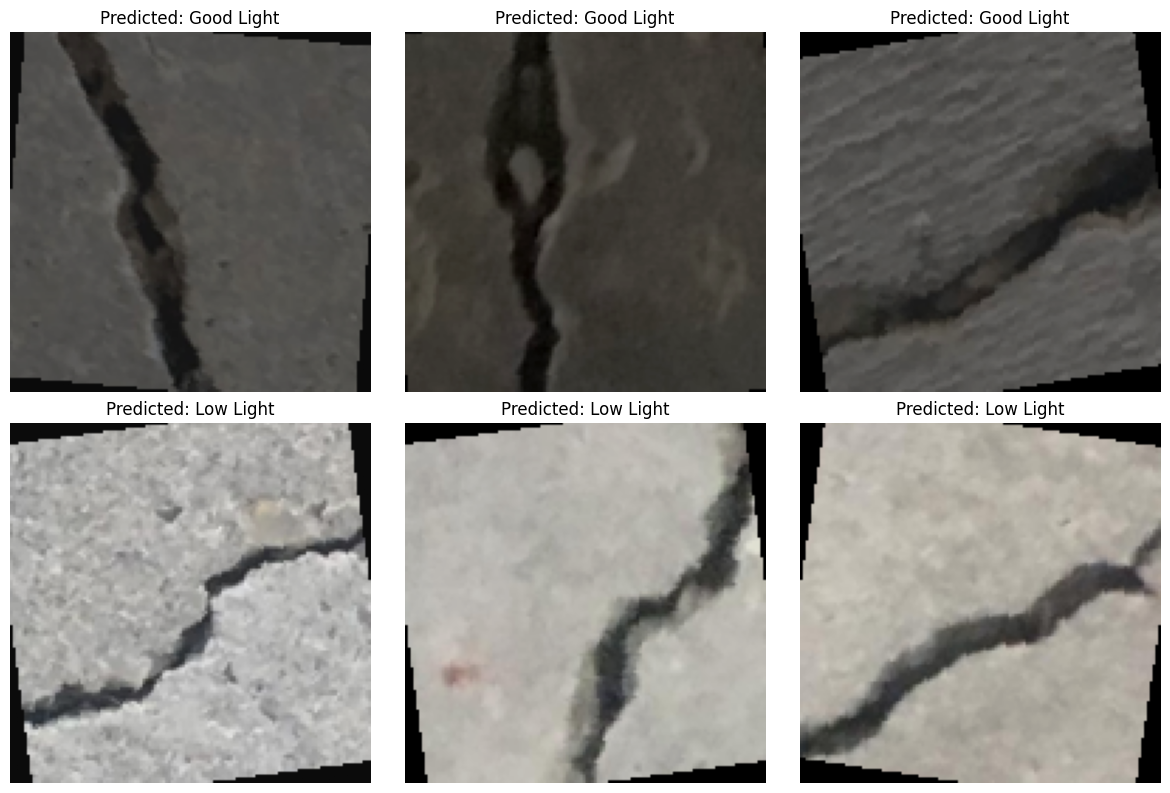

In [12]:
# Plot some predictions
def plot_predicted_images(model, dataloader, device, class_names=["Good Light", "Low Light"]):
    model.eval()  # Set the model to evaluation mode
    good_light_images, low_light_images = [], []  # Store images and labels
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted labels
            
            for img, pred in zip(images.cpu(), preds.cpu()):
                if pred == 0 and len(good_light_images) < 3:
                    good_light_images.append((img, pred))
                elif pred == 1 and len(low_light_images) < 3:
                    low_light_images.append((img, pred))
                
                # Stop when we have 3 images of each class
                if len(good_light_images) == 3 and len(low_light_images) == 3:
                    break
            if len(good_light_images) == 3 and len(low_light_images) == 3:
                break
    
    # Combine both sets of images for display
    all_images = good_light_images + low_light_images
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    for ax, (img, pred) in zip(axes, all_images):
        ax.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to image
        ax.set_title(f"Predicted: {class_names[pred.item()]}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Assuming test_dataloader is your test data loader
plot_predicted_images(model, test_loader, device)


In [13]:
# Save the model
torch.save(model.state_dict(), "low_light_classifier.pth")
print("Model saved as low_light_classifier.pth")


Model saved as low_light_classifier.pth
